In [1]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import optimize
from scipy import stats

Notes/questions/to-do
* In the case of $f \sim 10^{-4} - 10^{-2}$, which is more constraining: $\gamma$-ray point source or diffuse constraints? When can each be used?

In [3]:
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_m_sun = 1 / 1.11543e57
m_sun_to_GeV = 1 / GeV_to_m_sun
GeV_to_erg = 0.001602
erg_to_GeV = 1 / GeV_to_erg
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s
L_sun_to_GeV_s = 2.402e36
GeV_s_to_L_sun = 1 / L_sun_to_GeV_s
L_sun_to_erg_s = L_sun_to_GeV_s * GeV_to_erg
erg_s_to_L_sun = 1 / L_sun_to_erg_s

# Milky Way halo's virial radius, assuming an NFW profile
r_vir_mw_nfw = 8.28862681e11  # kpc
r_s_mw_nfw = 24.42  # kpc
# Sampling from this is EXTREMELY slow!
r_dist_nfw = stats.gausshyper(2, 1, 2, r_vir_mw_nfw/r_s_mw_nfw, scale=r_vir_mw_nfw)

# Best-fit Einasto parameters for Milky Way halo. From PPPC.
alpha_mw = 0.17
r_s_mw = 28.44  # kpc
rho_e_mw = 0.033 * GeV_to_m_sun / cm_to_kpc**3  # M_sun / kpc^3

def rho_einasto(r, rho_e, r_s, alpha):
    """Einasto density profile."""
    return rho_e * np.exp(-2/alpha * ((r / r_s)**alpha - 1))

# Corresponding probability distributions for coordinates. Cross-checked with r**2 * rho_einasto.
r_dist = stats.gengamma(a=3/alpha_mw, c=alpha_mw, loc=0, scale=(alpha_mw/2)**(1/alpha_mw) * r_s_mw)
cos_th_dist = stats.uniform(-1., 2.)
phi_dist = stats.uniform(0, 2*np.pi)

# Total MW DM mass in M_sun. Cross-checked with PPPC.
m_mw_dm = quad(lambda r: 4*np.pi*r**2*rho_einasto(r, rho_e_mw, r_s_mw, alpha_mw),
               0., np.inf, epsabs=0, epsrel=1e-4)[0]

Omega_cdm = 0.2589  # from Planck 2015
z_eq = 3500.
z_final = 30.  # redshift at which to end PBH halo evolution
d_earth = 20.33  # kpc
age_of_universe = 13e9  # yr
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))
# Particle physics
alpha_em = 1/137.
m_e = 0.511e-3  # GeV
m_mu = 105.7e-3  # GeV
m_tau = 1.776  # GeV

def gamma_spec_int(m_dm, e_low, e_high, fs="g g"):
    """Computes the energy flux, int dE E dN/dE.
    
    Notes
    -----
    Uses the Altarelli-Parisi approximation for FSR from leptons.
    
    Parameters
    ----------
    m_dm
        DM mass, GeV.
    e_low, e_high
        Energy interval, GeV.
    fs : string
    
    Returns
    -------
    Energy flux per annihilation in GeV.
    """
    if fs == "g g":
        if e_low <= m_dm <= e_high:
            return 2.*m_dm
        else:
            return 0.
    elif fs == "e e":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_e)
    elif fs == "mu mu":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_mu)
    elif fs == "tau tau":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_tau)
    else:
        raise ValueError("Unknown final state")

def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x + d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x + d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])

In [46]:
class PBHHaloSim(object):
    def __init__(self, mass_dist, f_pbh, m_dm=100, sv=3e-26, e_low=1, e_high=100,
                 fs="g g", dOmega=fermi_psf_solid_angle, b_cut=10, e_flux_thresh=4e-13):
        self.mass_dist = mass_dist
        self.f_pbh = f_pbh
        self.m_dm = m_dm
        self.sv = sv
        self.e_low = e_low
        self.e_high = e_high
        self.fs = fs
        self.dOmega = dOmega
        self.b_cut = b_cut
        self.e_flux_thresh = e_flux_thresh
    
    def _gen_positions(self):
        self.positions = np.stack([r_dist.rvs(self.n_samples),
                                   np.arccos(cos_th_dist.rvs(self.n_samples)),
                                   phi_dist.rvs(self.n_samples)])
        self.positions = to_galactic_coords(*self.positions)
        
    def _pbh_halo_ann_rates(self):
        """
        Notes
        -----
        From Byrnes2019.

        Returns
        -------
        UCMH annihilation rate in 1/s.
        """
        rho_max = self.m_dm / (self.sv * age_of_universe * yr_to_s)
        r_cut = 1.3e-7 * (100./self.m_dm * self.sv/3e-26)**(4/9) * (self.m_pbhs/1.)**(1/3)
        units_factor = kpc_to_cm**3
        return 4*np.pi*self.sv*rho_max**2 * r_cut**3 / (2*self.m_dm**2) * units_factor
    
#     def _pbh_halo_lums(self):
#         """
#         Notes
#         -----
#         From BL10. Results are extremely sensitive to r_tr, and the DM profile
#         in general!

#         Returns
#         -------
#         UCMH luminosity in erg/s.
#         """
#         r_p = 6.3e-6 * 4.848e-9 * self.m_pbhs**0.23
#         r_tr = 1300*4.848e-9 * self.m_pbhs**(1/3)
#         units_factor = m_sun_to_GeV**2 / kpc_to_cm**3 * GeV_to_erg
#         return (9/(32*np.pi) * self.m_pbhs**2 * self.sv / (self.m_dm * r_tr**3) *
#                 np.log(r_tr / r_p) * units_factor)
    
    def _gen_pbh_halos(self):
        if isinstance(self.mass_dist, numbers.Number):
            self.m_pbhs = np.array(self.mass_dist)
            self.ann_rates = self._pbh_halo_ann_rates()
            self.m_pbhs = self.m_pbhs * np.ones(self.n_samples)
            self.ann_rates = self.ann_rates * np.ones(self.n_samples)
        else:
            self.m_pbhs = mass_dist.rvs(self.n_samples)
            self.ann_rates = self._pbh_halo_ann_rates()
            
        self.num_halo_pbhs = self.f_pbh * m_mw_dm / np.mean(self.m_pbhs)
        
        units_factor = 1 / kpc_to_cm**2
        int_specs = gamma_spec_int(self.m_dm, self.e_low, self.e_high, self.fs)
        self.e_fluxes = self.ann_rates * self.dOmega/(4*np.pi*self.positions[0]**2) * int_specs * units_factor
    
    def _num_detectable_pbh_halos(self, b_cut=None, e_flux_thresh=None):
        # TODO: I don't think the error estimates are correct!
        if b_cut is not None:
            self.b_cut = b_cut
        if e_flux_thresh is not None:
            self.e_flux_thresh = e_flux_thresh
        # PBHs outside galactic plane
        passed_b_cut_idx = np.abs(self.positions[1]) > self.b_cut
        # PBHs above energy threshold
        passed_e_thresh_idx = self.e_fluxes > self.e_flux_thresh
        # Values in this array are set to one for PBHs passing all cuts
        self.passed_cuts = np.zeros(self.n_samples)
        self.passed_cuts[passed_b_cut_idx & passed_e_thresh_idx] = 1.
        # Probability for a PBH in the MW halo to pass all cuts
        self.pr_passed_cuts = np.mean(self.passed_cuts)
        # 95% confidence interval on estimate of this probability
        self.pr_passed_cuts_err = 1.96 * np.std(sim.passed_cuts) / np.sqrt(sim.n_samples)
        # MC estimate for number of detectable PBHs in MW halo
        self.num_detectable_pbhs = self.num_halo_pbhs * self.pr_passed_cuts
        self.num_detectable_pbhs_err = self.num_halo_pbhs * self.pr_passed_cuts_err
        return self.num_detectable_pbhs
    
    def run(self, n_samples):
        self.n_samples = n_samples
        self._gen_positions()
        self._gen_pbh_halos()
        self._num_detectable_pbh_halos()
        return self.num_detectable_pbhs

In [76]:
# sim = PBHHaloSim(mass_dist=30., f_pbh=2e-9, m_dm=100., sv=3e-26)
sim = PBHHaloSim(mass_dist=0.5, f_pbh=1e-3, m_dm=100., sv=5e-29)
print("# det PBHs = {} +/- {}".format(sim.run(10000000), sim.num_detectable_pbhs_err))

# det PBHs = 3798.5173682235277 +/- 3039.446003039919


Only need to scan over $(m_\chi, \langle \sigma v \rangle)$ grid since $N_{\mathrm{obs}}^{\gamma-\mathrm{srcs}}$ scales as $f_{\mathrm{PBH}}$!

Text(0, 0.5, '\\#')

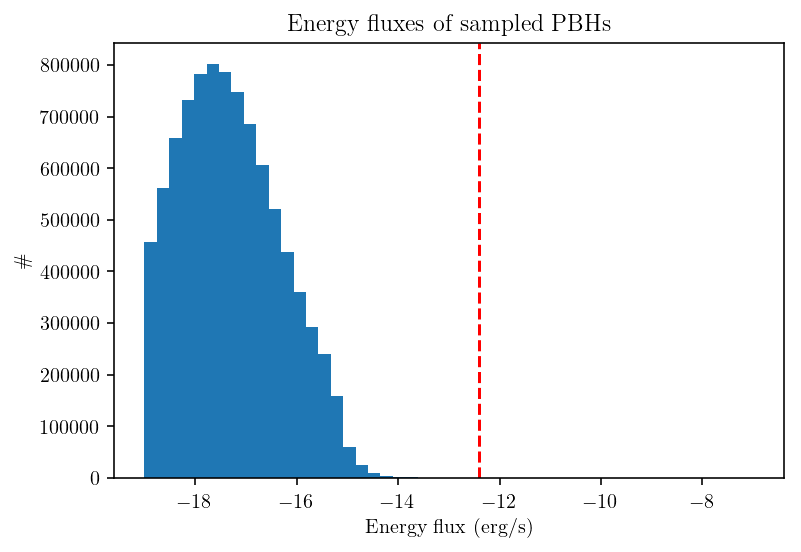

In [75]:
plt.hist(np.log10(sim.e_fluxes), bins=np.linspace(-19, -7))
plt.axvline(np.log10(sim.e_flux_thresh), color='r', linestyle='--')

plt.title("Energy fluxes of sampled PBHs")
plt.xlabel("Energy flux (erg/s)")
plt.ylabel("\#")

In [157]:
m_pbhs = np.logspace(-1, 2, 25)
n_det_pbhs = []
n_det_pbhs_err = []
for m_pbh in m_pbhs:
    sim = PBHHaloSim(mass_dist=m_pbh, f_pbh=5e-9, m_dm=100., sv=3e-26)
    n_det_pbhs.append(sim.run(1000000))
    n_det_pbhs_err.append(sim.num_detectable_pbhs_err)
n_det_pbhs = np.array(n_det_pbhs)
n_det_pbhs_err = np.array(n_det_pbhs_err)

Text(0.5, 1.0, '$f_{\\mathrm{PBH}} = 10^{-9}$, $m_{\\mathrm{DM}}=100$ GeV, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}$ cm$^3$/s, $E_{\\mathrm{thresh}}=4\\times 10^{-13}$ erg/s')

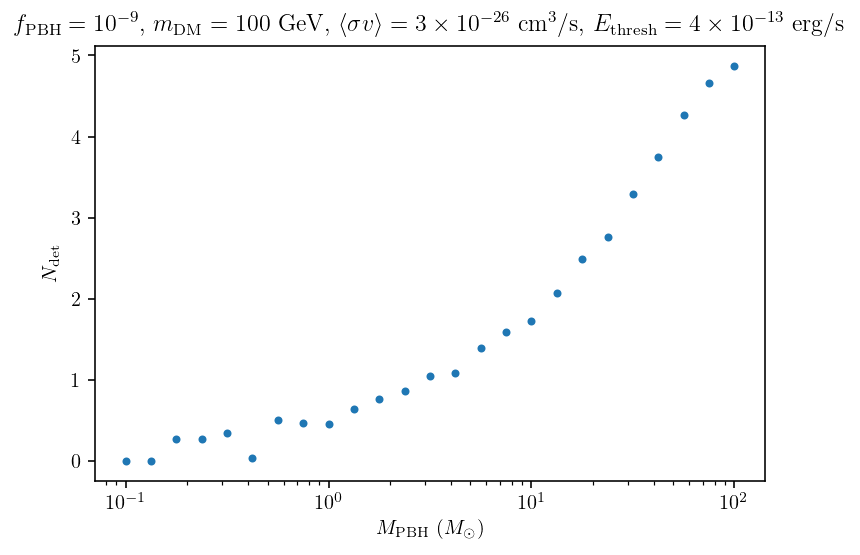

In [159]:
plt.errorbar(m_pbhs, n_det_pbhs, yerr=n_det_pbhs_err, fmt='.')
plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$M_{\mathrm{PBH}}$ ($M_\odot$)")
plt.ylabel(r"$N_{\mathrm{det}}$")
plt.title(r"$f_{\mathrm{PBH}} = 10^{-9}$, $m_{\mathrm{DM}}=100$ GeV, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}$ cm$^3$/s, $E_{\mathrm{thresh}}=4\times 10^{-13}$ erg/s")

Comparison with Visinelli's paper

In [10]:
num_anns = []
m_pbhs = np.logspace(-18, -4)

for m in m_pbhs:
    sim = PBHHaloSim(m, f_pbh=1, m_dm=10e3)
    sim.run(1)
    num_anns.append(sim._pbh_halo_ann_rates())# * erg_to_GeV / sim.m_dm)
num_anns = np.array(num_anns)

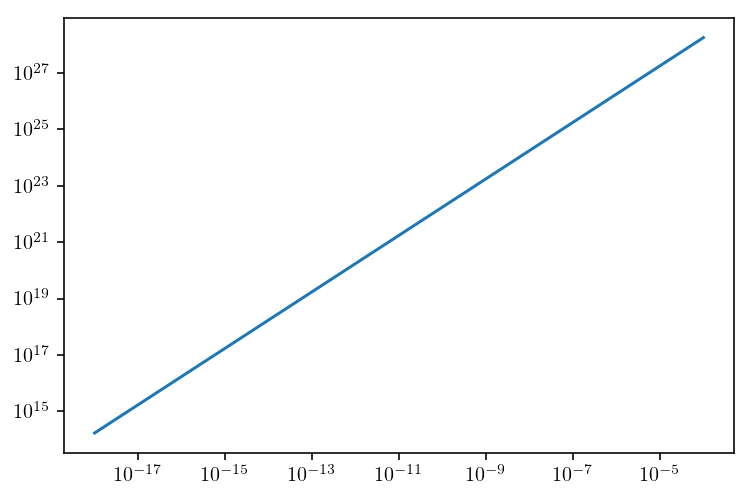

In [11]:
plt.loglog(m_pbhs, num_anns)

Byrnes' gamma-ray constraints. I find that he's over-optimistic by a factor of 1/3.

In [30]:
def constrain_f_pbh(m_pbh, m_dm=100, sv=3e-26):
    # Replicate Byrnes2019 constraints
    rho_max = m_dm / (sv * age_of_universe * yr_to_s)
    # kpc
    r_cut = (sv / 3e-26)**(4/9) * (m_dm / 100)**(-4/9) * (m_pbh / 1.)**(1/3) * 1.3e-7
    Gamma_pbh = 4*np.pi*sv*rho_max**2*r_cut**3 / m_dm**2 * kpc_to_cm**3
    Gamma_dm = 1e-28  # 1/s
    return Gamma_dm/Gamma_pbh * m_pbh*m_sun_to_GeV/m_dm

Text(0.5, 1.0, '$M_{\\mathrm{PBH}} = 30 M_\\odot$')

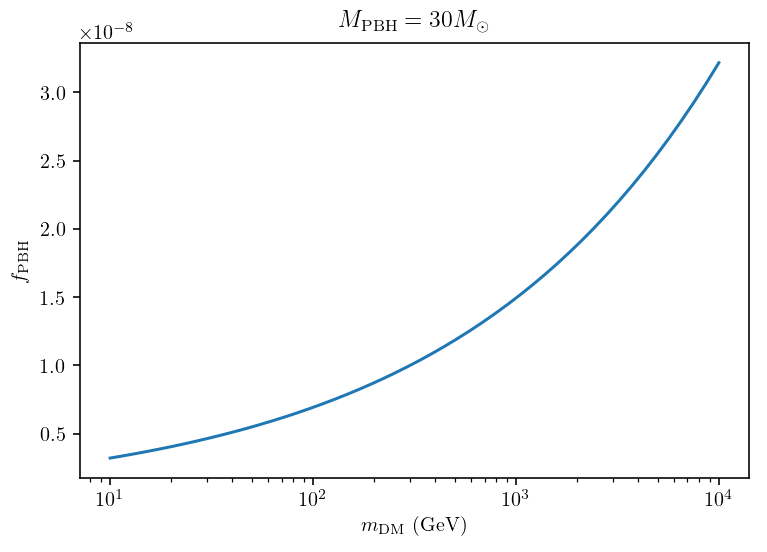

In [31]:
m_dms = np.logspace(1, 4)

plt.plot(m_dms, [constrain_f_pbh(30., m_dm) for m_dm in m_dms])
plt.xscale("log")

plt.xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
plt.ylabel(r"$f_{\mathrm{PBH}}$")
plt.title(r"$M_{\mathrm{PBH}} = 30 M_\odot$")

# Notes: point sources vs diffuse

Plugging in $M_{\mathrm{PBH}} = 30 M_\odot$, $f=10^{-8}$ and assuming a uniform angular distribution, we can compute the average angular radius around each PBH that does not contain another PBH. This angle is 50 times larger than Fermi's PSF. Since in reality sources are not uniformly distributed on the sky, this is a bit of an underestimate. **This means Byrnes' analysis is inconsistent: at such low $f$s, you need to perform a point source analysis to properly constrain $f$.**

In [57]:
n_pbhs_in_mw = 1e-8*(m_mw_dm / 30.)
avg_pbh_angular_sep = 2*np.sqrt((4*np.pi / n_pbhs_in_mw) / np.pi) / fermi_psf
print("<th_sep> / fermi_psf = %f" % avg_pbh_angular_sep)

<th_sep> / fermi_psf = 47.036560


Let's instead consider $f = 10^{-3}$ and $M_{\mathrm{PBH}} = 0.5 M_\odot$, which are interesting numbers for LIGO O3. In this case the average separation is much smaller than Fermi's PSF. This means the DM self-annihilation cross section must be very small for a point source search to be valid.

In [58]:
n_pbhs_in_mw = 1e-3*(m_mw_dm / 0.5)
avg_pbh_angular_sep = 2*np.sqrt((4*np.pi / n_pbhs_in_mw) / np.pi) / fermi_psf
print("<th_sep> / fermi_psf = %f" % avg_pbh_angular_sep)

<th_sep> / fermi_psf = 0.019203


# DM density profile
See [Luca Visinelli's paper](https://arxiv.org/abs/1712.06383)

In [123]:
import numba

In [210]:
def influence_radius(temp_kd, r_g=1.):
    return r_g * (2 * temp_kd / r_g)**(2/3)

def initial_density(r_i, r_infl, rho_kd):
    if r_i < r_infl:
        return rho_kd
    else:
        return rho_kd * (r_infl / r_i)**(9/4)

def kd_density(temp_kd):
    # TODO: put this in!
    return 1e-5
#     g_star_kd = 61.75
#     Omega_m = 0.27
#     t_eq = 2.4 / np.sqrt(10) * (0.75e-9 / 1e-3)**(-2)  # s
#     t_kd = 2.4 / np.sqrt(g_star_kd) * (temp_kd / 1e-3)**(-2)  # s
#     return Omega_m * rho_eq * (t_eq / t_kd)**(3/2)

def temperature(r_i, r_infl, temp_kd):
    if r_i < r_infl:
        return temp_kd
    else:
        return temp_kd * (r_infl / r_i)**(3/2)
    
def f_mb(beta_i, sigma):
    return np.exp(-beta_i**2 / (2*sigma**2)) / (2*np.pi*sigma**2)**(3/2)

def y_min(beta_i, r_i, r):
    return np.sqrt(1 + (r / r_i / beta_i)**2 * (1 / r_i - beta_i**2 - 1 / r))

def r_min_max(beta_i, r):
    r1 = r
    r2 = r/2 * (np.sqrt(1 + 4 / r / beta_i**2) - 1)
    if r1 < r2:
        return r1, r2
    else:
        return r2, r1
    
def ps_integrand(beta_i, r_i, r, m_dm, x_kd=1e-4, r_g=1.):
    if beta_i < 0 or r_i < 0 or r < 0:
        return 0.
    r_min, r_max = r_min_max(beta_i, r)
#     print(r_min, r_max)
#     print(1 / beta_i > r_i)
#     print(r_i > r / (1 + r * beta_i**2))
#     print(r_min > r_i, r_i > r_max)
    if 1 / beta_i > r_i and r_i > r / (1 + r * beta_i**2) and \
            (r_min > r_i or r_i > r_max):
        temp_kd = m_dm * x_kd
        rho_kd = kd_density(temp_kd)
        r_infl = influence_radius(temp_kd, r_g)
        sigma = np.sqrt(temperature(r_i, r_infl, temp_kd) / m_dm)
        factor_1 = 8/r * beta_i * f_mb(beta_i, sigma) * r_i * initial_density(r_i, r_infl, rho_kd)
        y_m = y_min(beta_i, r_i, r)
        x_m = np.sqrt(1 - y_m**2)
        factor_2 = (1 / r_i - beta_i**2)**(3/2) * np.log((1 + x_m) / y_m)
        return factor_1 * factor_2
    else:
        return 0.

In [196]:
from scipy.integrate import dblquad

In [216]:
dblquad(lambda bi, ri: ps_integrand(bi, ri, 0.0001, 100.),
        0, np.inf, lambda ri: 0, lambda ri: np.inf, epsabs=1e-200, epsrel=1e-5)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  **opt)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


(1.023037080247131e-09, 5.887327581292859e-09)

In [130]:
2 > 3 / (1 + 3 * 0.5**2)

True